Import and setup:
In this first cell we import many of the packages we will need later, rdkit is a package which helps us work with the molecular object generated by the neural network.
DIG is the package which allows us to work with Graph and DIG includes the dataset we will work with, and some methods for working with Graph neural networks.
torch_geometric is the name that Pytorch Geometric uses for import, this is the package that creates the Graph Neural Network, and does the computations.
The dataset we're importing is the Zinc250k dataset, which includes 250 thousand 

In [ ]:
!pip install rdkit-pypi
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.8.0+cu101.html
!pip install dive-into-graphs

In [9]:
import rdkit
from rdkit import Chem
import json
from dig.ggraph.dataset import ZINC250k
from torch_geometric.data import DenseDataLoader
conf = json.load(open('benchmarks/ggraph/GraphDF/config/rand_gen_zinc250k_config_dict.json'))
dataset = ZINC250k(one_shot=False, use_aug=True)
loader = DenseDataLoader(dataset, batch_size=conf['batch_size'], shuffle=True)

In [18]:
from dig.ggraph.method import GraphDF
runner = GraphDF()
lr = 0.001
wd = 0
max_epochs = 10
save_interval = 1
save_dir = 'rand_gen_zinc250k'
runner.train_rand_gen(loader=loader, lr=lr, wd=wd, max_epochs=max_epochs,
    model_conf_dict=conf['model'], save_interval=save_interval, save_dir=save_dir)

RuntimeError: The 'data' object was created by an older version of PyG. If this error occurred while loading an already existing dataset, remove the 'processed/' directory in the dataset's root folder and try again.

In [11]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
ckpt_path = 'rand_gen_zinc250k/rand_gen_ckpt_10.pth'
n_mols = 100
mols, _ = runner.run_rand_gen(model_conf_dict=conf['model'], checkpoint_path=ckpt_path,
    n_mols=n_mols, atomic_num_list=conf['atom_list'])


Generated 10 molecules
Generated 20 molecules
Generated 30 molecules
Generated 40 molecules
Generated 50 molecules
Generated 60 molecules
Generated 70 molecules
Generated 80 molecules
Generated 90 molecules
Generated 100 molecules


In [13]:
from rdkit.Chem import Draw
from rdkit.Chem import AllChem

for mol in mols: tmp=AllChem.Compute2DCoords(mol)

for num,mol in enumerate(mols):
    print(mols[num])
    #print(num)
    #Draw.MolToFile(mols[num],'DIG_mol{num}.png')    
#img=Draw.MolsToGridImage(mols[:8],molsPerRow=4,subImgSize=(200,200))  #img.save('molgrid.png')    

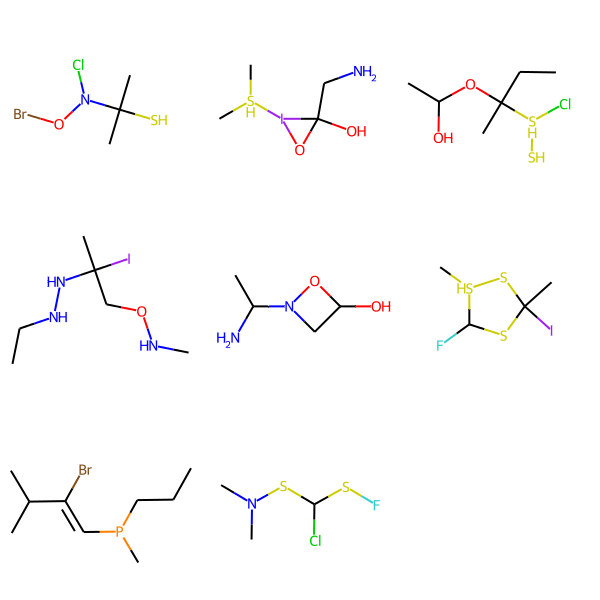

In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
Chem.Draw.MolsToGridImage(mols[0:8])
#img.save('molgrid.png')

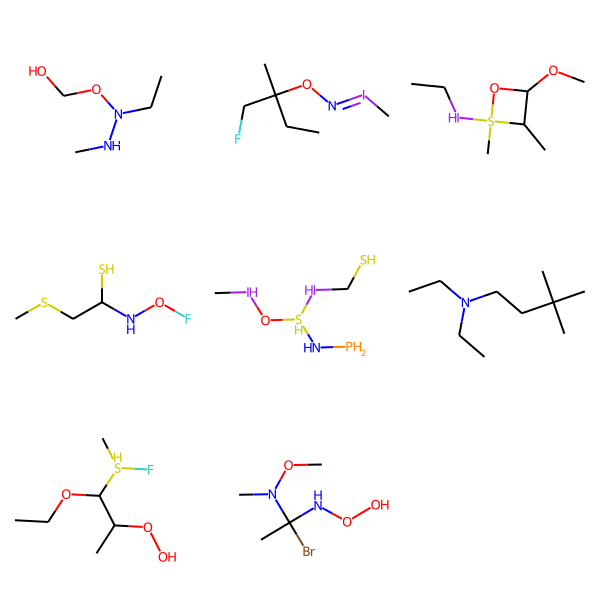

In [16]:
Chem.Draw.MolsToGridImage(mols[50:58])

Next we evaluate how 'unique' our resulting molecules are. This is easy to do because DIG includes a function which does exactly that. We can see all the molecules we have generated are unique, that is to say different from every other molecule in the dataset and in the set of generated molecules.

In [17]:
from dig.ggraph.evaluation import RandGenEvaluator
evaluator = RandGenEvaluator()
input_dict = {'mols': mols}
print('Evaluating...')
evaluator.eval(input_dict)

Evaluating...
Valid Ratio: 100/100 = 100.00%
Unique Ratio: 100/100 = 100.00%


{'valid_ratio': 100.0, 'unique_ratio': 100.0}

Being unique is a fairly (completely) useless property for molecule in the process of drug design, give a small child a plastic molecule buliding set and they can come up with unique molecules. So now we will optimize our output to match properties that we want, such as drug-likeness.

In [21]:
import requests
import json
from dig.ggraph.method import GraphDF
with open('benchmarks/ggraph/GraphDF/config/prop_opt_plogp_config_dict.json') as f:
    conf = json.load(f)
runner = GraphDF()
p=requests.get('https://github.com/divelab/DIG_storage/blob/main/ggraph/GraphDF/saved_ckpts/prop_opt/pretrain_plogp.pth?raw=true')

In [23]:
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

pretrain_path = p
lr = 0.0001
wd = 0
warm_up = 0
max_iters = 200
save_interval = 20
save_dir = 'prop_opt_plogp'
runner.train_prop_opt(lr=lr, wd=wd, max_iters=max_iters, warm_up=warm_up,
    model_conf_dict=conf['model'], pretrain_path=pretrain_path,
    save_interval=save_interval, save_dir=save_dir)

AttributeError: 'Response' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.